# Diversity analysis


In [155]:
import os
import pandas as pd
from qiime2 import Visualization
from skbio import OrdinationResults
import matplotlib.pyplot as plt
from seaborn import scatterplot
import numpy as np
import math
import seaborn as sns

from scipy import stats

import warnings
warnings.simplefilter(action='ignore')

import qiime2 as q2

%matplotlib inline
data_dir = 'CE'

Artifacts used for alpha-diversity (start)
- dada2_table_align_filtered.qza  --> taxonomy.ipynb
- fasttree-tree-rooted.qza  --> taxonomy.ipynb
- sepp-tree.qza  --> taxonomy.ipynb

## Alpha rarefaction

Which tree should be chosen to conduct alpha rarefaction? the de-novo tree or fragment insertion tree? 
-> fragment insertion tree was chosen, to get the completest tree possible with as much information as possible.
Artifacts of both trees are visualized here to have a look again:

In [2]:
#denovo
Visualization.load(f'{data_dir}/fasttree-tree-rooted.qzv')

<visualization: Visualization uuid: fa5be120-ab7c-44b2-890e-b75b49207148>

In [3]:
#fragment-insertion
Visualization.load(f'{data_dir}/sepp-tree-placements-tree.qzv')

<visualization: Visualization uuid: c3aa3b89-243a-450b-aa54-475736e5cbb5>

### The following steps were done to analyze alpha diversities.
1. The first thing I did was downloading the metadata again, as it somehow was missing in the directory file CE. If you already have the food-metadata.tsv run normally, if not, remove the hashtags # in the following two cells.
2. Used the `diversity alpha-rarefaction` plugin in order to decide which rarefying threshold is best suited for our data. 
3. Visualized the `diversity alpha-rarefaction` artifact (--p-max-depth 100000) to find out which sequencing depth should be used 
    - **12000** was chosen to not loose to many samples but also not loose too much diversity. Also no big differences were noticed between *de novo* and *fragment insertion tree*. At the end we used the *fragment insertion tree*.
4. Also tested different `diversity alpha-rarefaction` --p-max-depth to double check the chosen rarefaction depth. It was done for --p-max-depth 10000 and 50000.
5. Used `core-metrics-phylogenetic` plugin and inserted 12000 for --p-sampling-depth in order to get many different core-metrics artifacts.
6. Used `diversity alpha-group-significance` plugin to run some statistical tests (Kruskall-Wallis) for all four metrics: Faith PD, observed features, Shannon entropy and Pielou evenness
7. use `diversity alpha-correlation` to check for correlations between numeric colums -- such as longitude and latitude -- against the four metrics
8. a&b: some fun with pandas: creating a 2D plot of our data for the report (as it's in 2D) - having even some more fun with seaborn and matplotlib hehe

### beta diversity
9. Analysis of core metrics qzv files
10) PERMANOVA test: 
11) Adonis: to explain which covariants explain most variation in our data
12) Pandas fun: creating 2D plots for the report :)

### 1)

In [8]:
#! wget -nv -O $data_dir/food-metadata.tsv 'https://polybox.ethz.ch/index.php/s/nEd4l5CWGWGEtae/download'

2022-11-08 16:20:15 URL:https://polybox.ethz.ch/index.php/s/nEd4l5CWGWGEtae/download [42810/42810] -> "CE/food-metadata.tsv" [1]


In [12]:
#df_meta = pd.read_csv(f'{data_dir}/food-metadata.tsv', sep='\t', index_col=0)

### 2)

for denovo:

In [3]:
! qiime diversity alpha-rarefaction \
    --i-table $data_dir/dada2_table_align_filtered.qza \
    --i-phylogeny $data_dir/fasttree-tree-rooted.qza \
    --p-max-depth 100000 \
    --m-metadata-file $data_dir/food-metadata.tsv\
    --o-visualization $data_dir/alpha-rarefaction_denovo.qzv

Saved Visualization to: CE/alpha-rarefaction_denovo.qzv


for fragment insertion:

In [12]:
! qiime diversity alpha-rarefaction \
    --i-table $data_dir/dada2_table_align_filtered.qza \
    --i-phylogeny $data_dir/sepp-tree.qza \
    --p-max-depth 100000 \
    --m-metadata-file $data_dir/food-metadata.tsv\
    --o-visualization $data_dir/alpha-rarefaction_insertion.qzv

Saved Visualization to: CE/alpha-rarefaction_insertion.qzv


### 3)

In [2]:
#denovo tree: number of samples has plateau at around 7000 for rind-type
#could lower --p-max-depth to 10000 \
Visualization.load(f'{data_dir}/alpha-rarefaction_denovo.qzv')

<visualization: Visualization uuid: 56a6d917-f4fa-44a8-9c5b-eb1bf1dd4340>

In [3]:
#fragment insertion tree: number of samples has plateau at around 7000 for rind-type
#could change --p-max-depth  7000\
Visualization.load(f'{data_dir}/alpha-rarefaction_insertion.qzv')

<visualization: Visualization uuid: 451f3775-a4b4-4ef5-85a2-fc702c1dceea>

**Observation:** no major difference was found for denovo vs fragment insertion tree.
I would cut at 12000 and choose that as sequencing depth. The plateau is already reached for almost all fators then and the number of samples starts decreasing. With 12000 we don't loose too many samples. The high rarefaction depth stands for a good sequencing depth quality.


### 4)

--p-max-depth 10000

In [4]:
! qiime diversity alpha-rarefaction \
    --i-table $data_dir/dada2_table_align_filtered.qza \
    --i-phylogeny $data_dir/sepp-tree.qza \
    --p-max-depth 10000 \
    --m-metadata-file $data_dir/food-metadata.tsv\
    --o-visualization $data_dir/alpha-rarefaction_insertion_10000.qzv

Saved Visualization to: CE/alpha-rarefaction_insertion_10000.qzv


In [5]:
Visualization.load(f'{data_dir}/alpha-rarefaction_insertion_10000.qzv')

<visualization: Visualization uuid: 18202a81-4f32-4843-b6b1-264745313dad>

--p-max-depth 50000

In [8]:
! qiime diversity alpha-rarefaction \
    --i-table $data_dir/dada2_table_align_filtered.qza \
    --i-phylogeny $data_dir/sepp-tree.qza \
    --p-max-depth 50000 \
    --m-metadata-file $data_dir/food-metadata.tsv\
    --o-visualization $data_dir/alpha-rarefaction_insertion_50000.qzv

Saved Visualization to: CE/alpha-rarefaction_insertion_50000.qzv


In [9]:
Visualization.load(f'{data_dir}/alpha-rarefaction_insertion_50000.qzv')

<visualization: Visualization uuid: 05b66370-f55c-4e24-9666-796ee5c4eb2f>

**Observation:** 12'000 seems to be a good rarefaction depth also double checking using these two different max depths.

### 5)

## Diversity analysis

## Alpha diversity

Sequencing depth of 12000 for rarefaction: now let's have a look at the whitin-sample diversity (= alpha div.) Done for fragment-insertion tree.

In [4]:
! qiime diversity core-metrics-phylogenetic \
  --i-table $data_dir/dada2_table_align_filtered.qza \
  --i-phylogeny $data_dir/sepp-tree.qza \
  --m-metadata-file $data_dir/food-metadata.tsv \
  --p-sampling-depth 12000 \
  --output-dir $data_dir/core-metrics-results_insertion_12000

Saved FeatureTable[Frequency] to: CE/core-metrics-results_insertion_12000/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: CE/core-metrics-results_insertion_12000/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: CE/core-metrics-results_insertion_12000/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: CE/core-metrics-results_insertion_12000/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: CE/core-metrics-results_insertion_12000/evenness_vector.qza
Saved DistanceMatrix to: CE/core-metrics-results_insertion_12000/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: CE/core-metrics-results_insertion_12000/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: CE/core-metrics-results_insertion_12000/jaccard_distance_matrix.qza
Saved DistanceMatrix to: CE/core-metrics-results_insertion_12000/bray_curtis_distance_matrix.qza
Saved PCoAResults to: CE/core-metrics-results_insertion_12000/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults

### 6)

In [5]:
! qiime diversity alpha-group-significance \
  --i-alpha-diversity $data_dir/core-metrics-results_insertion_12000/faith_pd_vector.qza \
  --m-metadata-file $data_dir/food-metadata.tsv \
  --o-visualization $data_dir/core-metrics-results_insertion_12000/faith-pd-group-significance.qzv

Saved Visualization to: CE/core-metrics-results_insertion_12000/faith-pd-group-significance.qzv


In [2]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/faith-pd-group-significance.qzv')

<visualization: Visualization uuid: b666216f-7507-4a72-91a4-03c56417d2f4>

In [4]:
! qiime diversity alpha-group-significance \
  --i-alpha-diversity $data_dir/core-metrics-results_insertion_12000/observed_features_vector.qza \
  --m-metadata-file $data_dir/food-metadata.tsv \
  --o-visualization $data_dir/core-metrics-results_insertion_12000/observed_features-significance.qzv

Saved Visualization to: CE/core-metrics-results_insertion_12000/observed_features-significance.qzv


In [3]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/observed_features-significance.qzv')

<visualization: Visualization uuid: c03165a6-65d2-4cf1-a5f6-9ca5412a08b5>

In [6]:
! qiime diversity alpha-group-significance \
  --i-alpha-diversity $data_dir/core-metrics-results_insertion_12000/shannon_vector.qza \
  --m-metadata-file $data_dir/food-metadata.tsv \
  --o-visualization $data_dir/core-metrics-results_insertion_12000/shannon-significance.qzv

Saved Visualization to: CE/core-metrics-results_insertion_12000/shannon-significance.qzv


In [4]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/shannon-significance.qzv')

<visualization: Visualization uuid: 56dbf38a-d551-40da-929c-0010d99e1f5d>

In [8]:
! qiime diversity alpha-group-significance \
  --i-alpha-diversity $data_dir/core-metrics-results_insertion_12000/evenness_vector.qza \
  --m-metadata-file $data_dir/food-metadata.tsv \
  --o-visualization $data_dir/core-metrics-results_insertion_12000/evenness-significance.qzv

Saved Visualization to: CE/core-metrics-results_insertion_12000/evenness-significance.qzv


In [5]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/evenness-significance.qzv')

<visualization: Visualization uuid: 6ca0b998-c87c-4204-9834-51db56c4aa9e>

### 7)

In [7]:
! qiime diversity alpha-correlation \
  --i-alpha-diversity $data_dir/core-metrics-results_insertion_12000/faith_pd_vector.qza \
  --m-metadata-file $data_dir/food-metadata.tsv \
  --o-visualization $data_dir/core-metrics-results_insertion_12000/faith-pd-group-significance-numeric.qzv

Saved Visualization to: CE/core-metrics-results_insertion_12000/faith-pd-group-significance-numeric.qzv


In [6]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/faith-pd-group-significance-numeric.qzv')

<visualization: Visualization uuid: eb2de2af-9b74-4497-8e1e-9993bfbd15e1>

In [10]:
! qiime diversity alpha-correlation \
  --i-alpha-diversity $data_dir/core-metrics-results_insertion_12000/observed_features_vector.qza \
  --m-metadata-file $data_dir/food-metadata.tsv \
  --o-visualization $data_dir/core-metrics-results_insertion_12000/observed_features_correlation.qzv

Saved Visualization to: CE/core-metrics-results_insertion_12000/observed_features_correlation.qzv


In [7]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/observed_features_correlation.qzv')

<visualization: Visualization uuid: 458be753-6461-4cb4-a6b0-f739fafc2e0d>

In [12]:
! qiime diversity alpha-correlation \
  --i-alpha-diversity $data_dir/core-metrics-results_insertion_12000/shannon_vector.qza \
  --m-metadata-file $data_dir/food-metadata.tsv \
  --o-visualization $data_dir/core-metrics-results_insertion_12000/shannon_correlation.qzv

Saved Visualization to: CE/core-metrics-results_insertion_12000/shannon_correlation.qzv


In [8]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/shannon_correlation.qzv')

<visualization: Visualization uuid: d169455d-993a-4dcb-b13c-42a5d718e6c4>

In [16]:
! qiime diversity alpha-correlation \
  --i-alpha-diversity $data_dir/core-metrics-results_insertion_12000/evenness_vector.qza \
  --m-metadata-file $data_dir/food-metadata.tsv \
  --o-visualization $data_dir/core-metrics-results_insertion_12000/evenness_correlation.qzv

Saved Visualization to: CE/core-metrics-results_insertion_12000/evenness_correlation.qzv


In [9]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/evenness_correlation.qzv')

<visualization: Visualization uuid: 2f4c1716-6415-443b-adb0-8fad10486756>

No correlation was visible

### 8a)

#### PANDAS boxplot visualization

In [15]:
#get artifact as series and se variable for metadata column
art = q2.Artifact.load(os.path.join(data_dir, 'core-metrics-results_insertion_12000/faith_pd_vector.qza')).view(pd.Series)
md = pd.read_csv(os.path.join(data_dir, 'food-metadata.tsv'), sep='\t', index_col=0)['rindtype']

In [16]:
#concat the columns into a table
pd.concat([art, md], join = 'inner', axis = 1)

,faith_pd,rindtype
11488.CSB280,9.111393,natural
11488.CSB281,10.492586,natural
11488.CSB282,9.983138,natural
11488.CSB290,4.539658,washed
11488.CSB292,3.130709,washed
...,...,...
11488.CSB980,8.061571,natural
11488.CSB981,6.614198,natural
11488.CSB984,10.555242,natural
11488.CSB985,11.277596,washed


In [17]:
#no change, same rows and columns, dropping empty values
artmd = pd.concat([art, md], join = 'inner', axis = 1).dropna()

Text(0.5, 0, 'Rind Type')

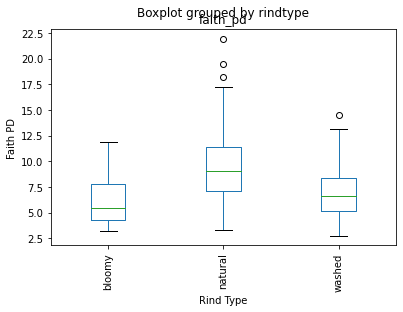

In [18]:
#creating the boxplot
artmd.boxplot(by = 'rindtype', rot=90, grid = False)
plt.ylabel('Faith PD')
plt.xlabel('Rind Type')

### 8b) 
Going crazy with visualizations. Going through different options, such as plot-type and colors.
Don't forget to run the next three cells whenever you want to run a plot-creation, as these are the crucial defining cells :)

In [156]:
#loading metric artifacts as series, as well as all metadata columns!
#maybe there would be a faster way but doing it like this allows quick changes if sth doesn't work and
#is easier to change certain categorical columns into numeric ones later down the line..
faith = q2.Artifact.load(os.path.join(data_dir, 'core-metrics-results_insertion_12000/faith_pd_vector.qza')).view(pd.Series)
obs_feat = q2.Artifact.load(os.path.join(data_dir, 'core-metrics-results_insertion_12000/observed_features_vector.qza')).view(pd.Series)
shannon = q2.Artifact.load(os.path.join(data_dir, 'core-metrics-results_insertion_12000/shannon_vector.qza')).view(pd.Series)
evenness = q2.Artifact.load(os.path.join(data_dir, 'core-metrics-results_insertion_12000/evenness_vector.qza')).view(pd.Series)
salt = pd.read_csv(os.path.join(data_dir, 'food-metadata.tsv'), sep='\t', index_col=0)['salt']
moisture = pd.read_csv(os.path.join(data_dir, 'food-metadata.tsv'), sep='\t', index_col=0)['moisture']
ph = pd.read_csv(os.path.join(data_dir, 'food-metadata.tsv'), sep='\t', index_col=0)['ph']
lat = pd.read_csv(os.path.join(data_dir, 'food-metadata.tsv'), sep='\t', index_col=0)['latitude']
lon = pd.read_csv(os.path.join(data_dir, 'food-metadata.tsv'), sep='\t', index_col=0)['longitude']
rindtype = pd.read_csv(os.path.join(data_dir, 'food-metadata.tsv'), sep='\t', index_col=0)['rindtype']
style = pd.read_csv(os.path.join(data_dir, 'food-metadata.tsv'), sep='\t', index_col=0)['style']
name = pd.read_csv(os.path.join(data_dir, 'food-metadata.tsv'), sep='\t', index_col=0)['name']
continent = pd.read_csv(os.path.join(data_dir, 'food-metadata.tsv'), sep='\t', index_col=0)['continent']
country = pd.read_csv(os.path.join(data_dir, 'food-metadata.tsv'), sep='\t', index_col=0)['country']
region = pd.read_csv(os.path.join(data_dir, 'food-metadata.tsv'), sep='\t', index_col=0)['region']
animal = pd.read_csv(os.path.join(data_dir, 'food-metadata.tsv'), sep='\t', index_col=0)['animal_source']
past = pd.read_csv(os.path.join(data_dir, 'food-metadata.tsv'), sep='\t', index_col=0)['pasteurized']



In [157]:
#concat everything into one table
metrics_md = pd.concat([faith, obs_feat, shannon, evenness, salt, moisture, ph, lat, lon, rindtype, style, name, continent, country, region, animal, past], join = 'inner', axis = 1)
metrics_md
#very nice :D - also no annoying index that would need to be removed visible.

,faith_pd,observed_features,shannon_entropy,pielou_evenness,salt,moisture,ph,latitude,longitude,rindtype,style,name,continent,country,region,animal_source,pasteurized
11488.CSB280,9.111393,25,1.641100,0.353392,0.045997737,34.80519481,6.55,41.611893,-73.210236,natural,NaN,Bethlehem,North_America,USA,Connecticut,cow,N
11488.CSB281,10.492586,24,2.611748,0.569633,0.068926154,31.33333333,6.54,41.611893,-73.210236,natural,NaN,Bethlehem,North_America,USA,Connecticut,cow,N
11488.CSB282,9.983138,23,2.348323,0.519131,0.030862483,34.90566038,6.55,41.611893,-73.210236,natural,NaN,Bethlehem,North_America,USA,Connecticut,cow,N
11488.CSB290,4.539658,15,2.502991,0.640661,0.220927133,18.88111888,6.29,43.054545,-90.136253,washed,alpine,Pleasant_Ridge_Reserve,North_America,USA,Wisconsin,cow,N
11488.CSB292,3.130709,12,2.353644,0.656532,0.0850591,22.89156627,6.1,43.054545,-90.136253,washed,alpine,Pleasant_Ridge_Reserve,North_America,USA,Wisconsin,cow,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11488.CSB980,8.061571,24,1.923263,0.419472,0.134996023,28.20512821,7.02,42.573335,-90.23096,natural,blue,Dunbarton_Blue,North_America,USA,Wisconsin,cow,Y
11488.CSB981,6.614198,20,1.473463,0.340927,0.102762839,25.76153177,7.09,42.573335,-90.23096,natural,blue,Dunbarton_Blue,North_America,USA,Wisconsin,cow,Y
11488.CSB984,10.555242,20,2.549971,0.590008,0.285081837,28.84012539,7.41,42.573335,-90.23096,natural,clothbound,Bandaged_Cheddar,North_America,USA,Wisconsin,cow,Y
11488.CSB985,11.277596,56,2.460126,0.423623,0.109716632,24.9661705,7.06,43.017497,-89.832345,washed,alpine,Alpine_Renegade,North_America,USA,Wisconsin,cow,N


In [158]:
#change from categorical to numeric for ph, salt, moisture (faith was just a double checking thing)
metrics_md['salt'] = pd.to_numeric(metrics_md['salt'], errors ='coerce')
metrics_md['moisture'] = pd.to_numeric(metrics_md['moisture'], errors ='coerce')
metrics_md['ph'] = pd.to_numeric(metrics_md['ph'], errors ='coerce')
metrics_md['faith_pd'] = pd.to_numeric(metrics_md['faith_pd'], errors ='coerce')

Text(0.5, 0, 'Rind Type')

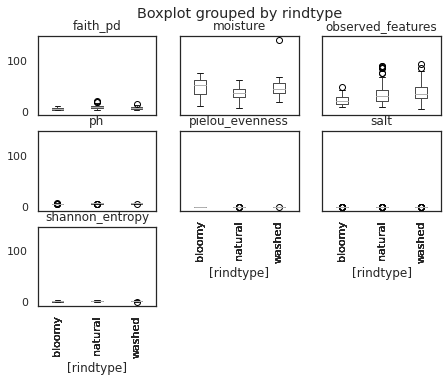

In [27]:
#fun little overview of numeric values grouped by rindtype
metrics_md.boxplot(by = 'rindtype', rot=90, grid = False)
plt.xlabel('Rind Type')

Text(0.5, 0, 'Rind Type')

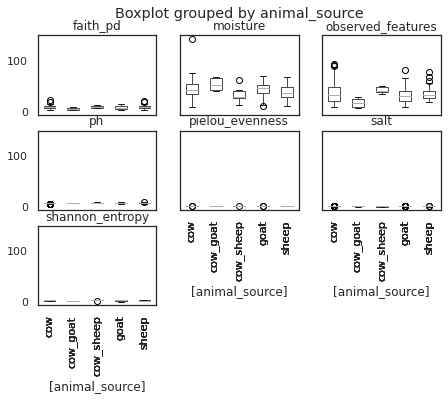

In [29]:
#let's make another one grouped by animal source
metrics_md.boxplot(by = 'animal_source', rot=90, grid = False)
plt.xlabel('Rind Type')

Text(0.5, 0, 'animal source')

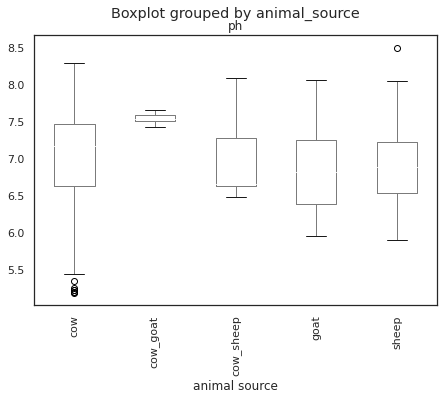

In [147]:
#let's have a look at the pH of cheeses from different animal sources:
animal_ph = pd.concat([ph, animal], join = 'inner', axis = 1)
animal_ph['ph'] = pd.to_numeric(animal_ph['ph'], errors ='coerce')
#get rid of the #q2:types "NaN" value in pH column:
animal_ph = animal_ph.drop(index='#q2:types')
#plot
animal_ph.boxplot(by = 'animal_source', rot=90, grid = False)
plt.xlabel('animal source')
#there is not a huge visual difference in pH median values between the pure milks. 
#I thought maybe lower pH values would be visible for milk with more lactose,
#as lactose is consumed by MO and "changed" into lactate (drop of pH)
#cow>sheep>goat is the lactose % in milk (https://www.researchgate.net/figure/Lactose-content-of-cow-sheep-buffalo-and-goat-milk-samples_fig4_312583378), 
#so here it would just be the other way around: cow-cheeses are having the highest pH...
#but differences in lactose content are very small anyways

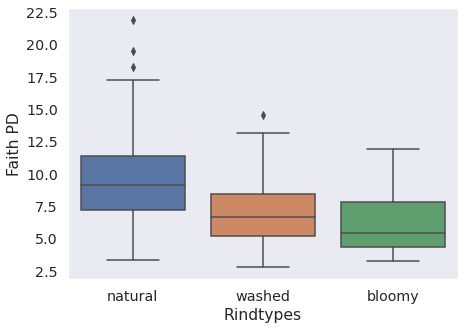

In [149]:
#now I decided to produce some beatiful boxplots for our report, instead of screenshotting the 
#visualization outputs from the statistical tests :)
sns.set(rc={'figure.figsize':(7, 5), 'font.family': ['DejaVu Sans']}, style='dark')
with sns.plotting_context("notebook", font_scale=1.3):
    # seaborn's boxplot
    ax = sns.boxplot(
        data=metrics_md, 
        x=metrics_md['rindtype'], 
        y=metrics_md['faith_pd']
    )
    
    # matplotlib's customization
    ax.set_xlabel('Rindtypes')
    ax.set_ylabel('Faith PD')

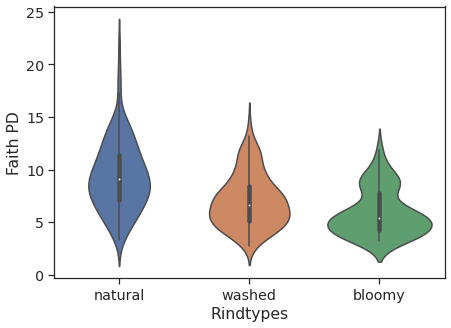

In [148]:
#I wanted to try a different plot look - violin
sns.set(rc={'figure.figsize':(7, 5), 'font.family': ['DejaVu Sans']}, style='ticks')
with sns.plotting_context("notebook", font_scale=1.3):
    # seaborn
    ax = sns.violinplot(
        data=metrics_md, 
        x=metrics_md['rindtype'], 
        y=metrics_md['faith_pd']
    )
    
    # matplotlib's customization
    ax.set_xlabel('Rindtypes')
    ax.set_ylabel('Faith PD')

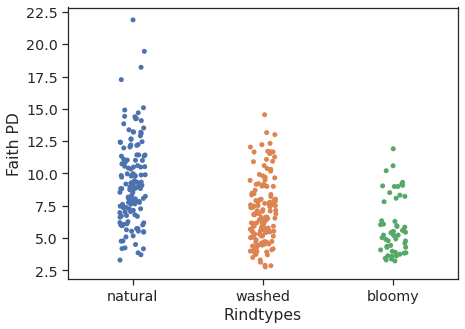

In [45]:
#I wanted to try a different plot look - strip plot
sns.set(rc={'figure.figsize':(7, 5), 'font.family': ['DejaVu Sans']}, style='ticks')
with sns.plotting_context("notebook", font_scale=1.3):
    # seaborn
    ax = sns.stripplot(
        data=metrics_md, 
        x=metrics_md['rindtype'], 
        y=metrics_md['faith_pd']
    )
    
    # matplotlib's customization
    ax.set_xlabel('Rindtypes')
    ax.set_ylabel('Faith PD')

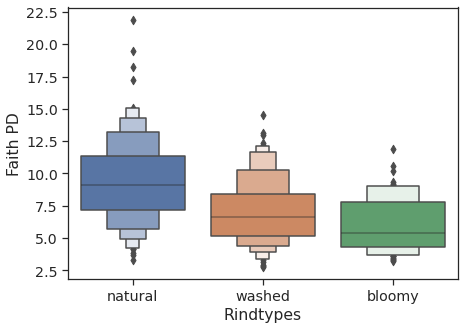

In [49]:
#I wanted to try a different plot look - boxen plot
sns.set(rc={'figure.figsize':(7, 5), 'font.family': ['DejaVu Sans']}, style='ticks')
with sns.plotting_context("notebook", font_scale=1.3):
    # seaborn
    ax = sns.boxenplot(
        data=metrics_md, 
        x=metrics_md['rindtype'], 
        y=metrics_md['faith_pd']
    )
    
    # matplotlib's customization
    ax.set_xlabel('Rindtypes')
    ax.set_ylabel('Faith PD')

#can get more info than boxplot, as it's kind of a mix between violin and boxplot... but it's rather ugly lol

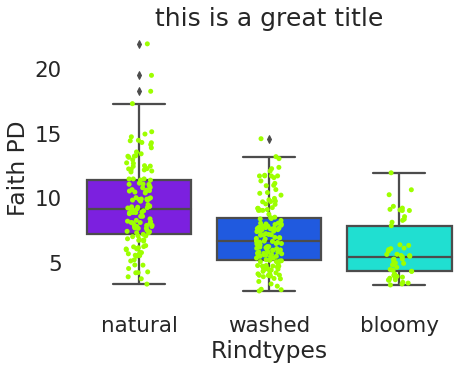

In [152]:
#how about a boxplot with dots inside!
#..and a different color ;)
sns.set(rc={'figure.figsize':(7, 5)}, style='white')
with sns.plotting_context("talk", font_scale=1.3):

    #set a palette
    sns.set_palette("gist_rainbow_r")
    
    #boxplot with title!
    ax = sns.boxplot(
            data=metrics_md, 
            x=metrics_md['rindtype'], 
            y=metrics_md['faith_pd']
        ).set_title(
  'this is a great title', fontdict = { 'fontsize': 25})
    
    #adding the dots
    ax = sns.stripplot(
        data=metrics_md, 
        x=metrics_md['rindtype'], 
        y=metrics_md['faith_pd'],
        color="C4"
    )
    #getting rid of the outer lines
    sns.despine(trim=True, left=True, bottom=True)
    
    # matplotlib's customization
    ax.set_xlabel('Rindtypes')
    ax.set_ylabel('Faith PD')
    
#okay, thats pretty cool, but too much clutter.. lets stay basic and use simple plots :)

---

In [159]:
#double check
metrics_md

,faith_pd,observed_features,shannon_entropy,pielou_evenness,salt,moisture,ph,latitude,longitude,rindtype,style,name,continent,country,region,animal_source,pasteurized
11488.CSB280,9.111393,25,1.641100,0.353392,0.045998,34.805195,6.55,41.611893,-73.210236,natural,NaN,Bethlehem,North_America,USA,Connecticut,cow,N
11488.CSB281,10.492586,24,2.611748,0.569633,0.068926,31.333333,6.54,41.611893,-73.210236,natural,NaN,Bethlehem,North_America,USA,Connecticut,cow,N
11488.CSB282,9.983138,23,2.348323,0.519131,0.030862,34.905660,6.55,41.611893,-73.210236,natural,NaN,Bethlehem,North_America,USA,Connecticut,cow,N
11488.CSB290,4.539658,15,2.502991,0.640661,0.220927,18.881119,6.29,43.054545,-90.136253,washed,alpine,Pleasant_Ridge_Reserve,North_America,USA,Wisconsin,cow,N
11488.CSB292,3.130709,12,2.353644,0.656532,0.085059,22.891566,6.10,43.054545,-90.136253,washed,alpine,Pleasant_Ridge_Reserve,North_America,USA,Wisconsin,cow,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11488.CSB980,8.061571,24,1.923263,0.419472,0.134996,28.205128,7.02,42.573335,-90.23096,natural,blue,Dunbarton_Blue,North_America,USA,Wisconsin,cow,Y
11488.CSB981,6.614198,20,1.473463,0.340927,0.102763,25.761532,7.09,42.573335,-90.23096,natural,blue,Dunbarton_Blue,North_America,USA,Wisconsin,cow,Y
11488.CSB984,10.555242,20,2.549971,0.590008,0.285082,28.840125,7.41,42.573335,-90.23096,natural,clothbound,Bandaged_Cheddar,North_America,USA,Wisconsin,cow,Y
11488.CSB985,11.277596,56,2.460126,0.423623,0.109717,24.966171,7.06,43.017497,-89.832345,washed,alpine,Alpine_Renegade,North_America,USA,Wisconsin,cow,N


In [15]:
#create a subset 1 of our metrics_md dataframe for the next step
subset1 = metrics_md[['faith_pd', 'observed_features', 'shannon_entropy', 'pielou_evenness', 'rindtype']]
subset1
#subset1=rindtype

,faith_pd,observed_features,shannon_entropy,pielou_evenness,rindtype
11488.CSB280,9.111393,25,1.641100,0.353392,natural
11488.CSB281,10.492586,24,2.611748,0.569633,natural
11488.CSB282,9.983138,23,2.348323,0.519131,natural
11488.CSB290,4.539658,15,2.502991,0.640661,washed
11488.CSB292,3.130709,12,2.353644,0.656532,washed
...,...,...,...,...,...
11488.CSB980,8.061571,24,1.923263,0.419472,natural
11488.CSB981,6.614198,20,1.473463,0.340927,natural
11488.CSB984,10.555242,20,2.549971,0.590008,natural
11488.CSB985,11.277596,56,2.460126,0.423623,washed


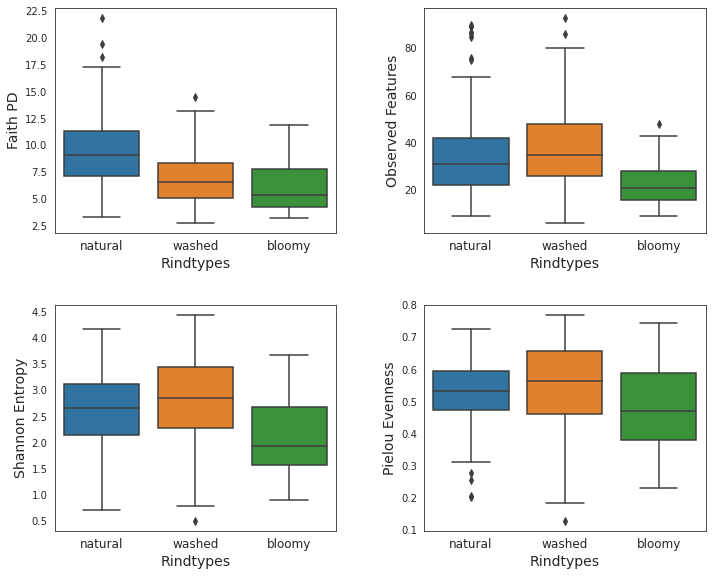

In [100]:
#boxplots
with sns.axes_style("white"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
    fig.subplots_adjust(top=0.8)
    
    # just like above but the "axes" array is now two-dimensional
    ax1 = sns.boxplot(data=subset1, x='rindtype', y='faith_pd', ax=axes[0, 0])
    ax2 = sns.boxplot(data=subset1, x='rindtype', y='observed_features', ax=axes[0, 1])
    ax3 = sns.boxplot(data=subset1, x='rindtype', y='shannon_entropy', ax=axes[1, 0])
    ax4 = sns.boxplot(data=subset1, x='rindtype', y='pielou_evenness', ax=axes[1, 1])

fig.tight_layout()

# set title and labels for individual plots
#ax1.set_title('Faith PD', fontsize=12)
ax1.set_ylabel('Faith PD', fontsize=14)
ax1.set_xlabel('Rindtypes', fontsize=14)
ax1.tick_params(axis='x', labelsize=12)
ax2.set_ylabel('Observed Features', fontsize=14)
ax2.set_xlabel('Rindtypes', fontsize=14)
ax2.tick_params(axis='x', labelsize=12)
# ax2.yaxis.set_label_position("right")
# better left with more space in between:
fig.tight_layout(w_pad=5, h_pad=3)

ax3.set_ylabel('Shannon Entropy', fontsize=14)
ax3.set_xlabel('Rindtypes', fontsize=14)
ax3.tick_params(axis='x', labelsize=12)
ax4.set_ylabel('Pielou Evenness', fontsize=14)
ax4.set_xlabel('Rindtypes', fontsize=14)
ax4.tick_params(axis='x', labelsize=12)

# title for the figure removed, as it's for the report
# fig.suptitle('alpha diversity metrics of different rindtypes', fontsize=16, y= 1.02);

#and finaly let's save the figure :D
#fig.savefig("rindtypes_metrics_boxplots_22.png", dpi = 400)

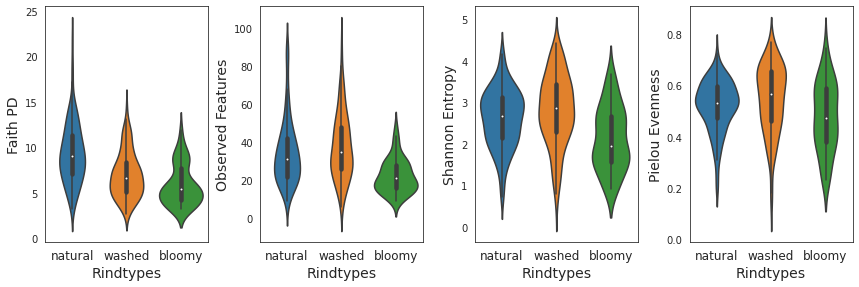

In [109]:
#let's try violin-plots and only one row to take up less (height) space in the report
with sns.axes_style("white"):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
    #fig.subplots_adjust(top=0.8)
    
    # just like above but the "axes" array is now two-dimensional
    ax1 = sns.violinplot(data=subset1, x='rindtype', y='faith_pd', ax=axes[0])
    ax2 = sns.violinplot(data=subset1, x='rindtype', y='observed_features', ax=axes[1])
    ax3 = sns.violinplot(data=subset1, x='rindtype', y='shannon_entropy', ax=axes[2])
    ax4 = sns.violinplot(data=subset1, x='rindtype', y='pielou_evenness', ax=axes[3])

fig.tight_layout()

# set title and labels for individual plots
#ax1.set_title('Faith PD', fontsize=12)
ax1.set_ylabel('Faith PD', fontsize=14)
ax1.set_xlabel('Rindtypes', fontsize=14)
ax1.tick_params(axis='x', labelsize=12)
ax2.set_ylabel('Observed Features', fontsize=14)
ax2.set_xlabel('Rindtypes', fontsize=14)
ax2.tick_params(axis='x', labelsize=12)
# ax2.yaxis.set_label_position("right")
# better left with more space in between:
#fig.tight_layout(h_pad=3)

ax3.set_ylabel('Shannon Entropy', fontsize=14)
ax3.set_xlabel('Rindtypes', fontsize=14)
ax3.tick_params(axis='x', labelsize=12)
ax4.set_ylabel('Pielou Evenness', fontsize=14)
ax4.set_xlabel('Rindtypes', fontsize=14)
ax4.tick_params(axis='x', labelsize=12)

# title for the figure removed, as it's for the report
# fig.suptitle('alpha diversity metrics of different rindtypes', fontsize=16, y= 1.02);

#and finaly let's save the figure :D
#fig.savefig("rindtypes_metrics_violinplot_14.png", dpi = 400)

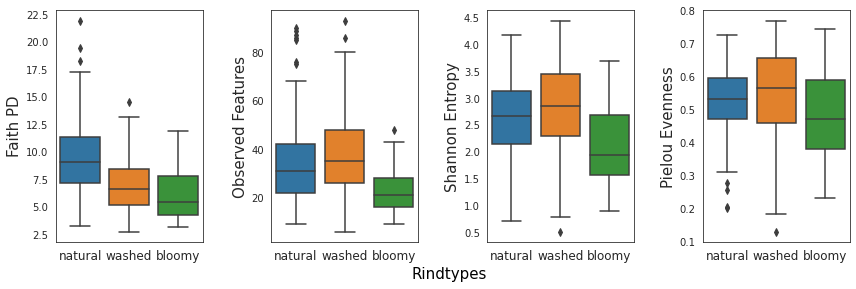

In [154]:
#let's try boxplots again and only one row to take up less (height) space in the report
with sns.axes_style("white"):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
    #fig.subplots_adjust(top=0.8)
    
    # just like above but the "axes" array is now two-dimensional
    ax1 = sns.boxplot(data=subset1, x='rindtype', y='faith_pd', ax=axes[0])
    ax2 = sns.boxplot(data=subset1, x='rindtype', y='observed_features', ax=axes[1])
    ax3 = sns.boxplot(data=subset1, x='rindtype', y='shannon_entropy', ax=axes[2])
    ax4 = sns.boxplot(data=subset1, x='rindtype', y='pielou_evenness', ax=axes[3])

fig.tight_layout()

# set title and labels for individual plots
#ax1.set_title('Faith PD', fontsize=12)
ax1.set_ylabel('Faith PD', fontsize=15)
ax1.set(xlabel=None)
ax1.tick_params(axis='x', labelsize=12)
ax2.set_ylabel('Observed Features', fontsize=15)
ax2.set_xlabel('')
ax2.tick_params(axis='x', labelsize=12)

fig.tight_layout(w_pad=3)

ax3.set_ylabel('Shannon Entropy', fontsize=15)
ax3.set_xlabel('')
ax3.tick_params(axis='x', labelsize=12)
ax4.set_ylabel('Pielou Evenness', fontsize=15)
ax4.set_xlabel('')
ax4.tick_params(axis='x', labelsize=12)

fig.supxlabel('Rindtypes', fontsize=15, x= 0.524, y=0.0075)
#fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')
# title for the figure removed, as it's for the report
# fig.suptitle('alpha diversity metrics of different rindtypes', fontsize=16, y= 1.02);

#and finaly let's save the figure :D
#fig.savefig("rindtypes_metrics_boxplot_14.png", dpi = 400)

The group decided on violinplots and one x-axis label. Also it was decided to keep the default color scheme to have coordinated colours across the report. So let's get creating the next violinplots for our remaining columns! Yeehaww B-)

---

In [162]:
#create subsets for all column-metric-visualizations:
#subset1 = rindtype
subset1 = metrics_md[['faith_pd', 'observed_features', 'shannon_entropy', 'pielou_evenness', 'rindtype']]

#subset2 = pasteurization and continents
subset2 = metrics_md[['faith_pd', 'observed_features', 'shannon_entropy', 'pielou_evenness', 'pasteurized', 'continent']]

#subset3 = cheese style
subset3 = metrics_md[['faith_pd', 'observed_features', 'shannon_entropy', 'pielou_evenness', 'style']]

#subset4 = animal source
subset4 = metrics_md[['faith_pd', 'observed_features', 'shannon_entropy', 'pielou_evenness', 'animal_source']]

#subset4 = countries
subset5 = metrics_md[['faith_pd', 'observed_features', 'shannon_entropy', 'pielou_evenness', 'country']]

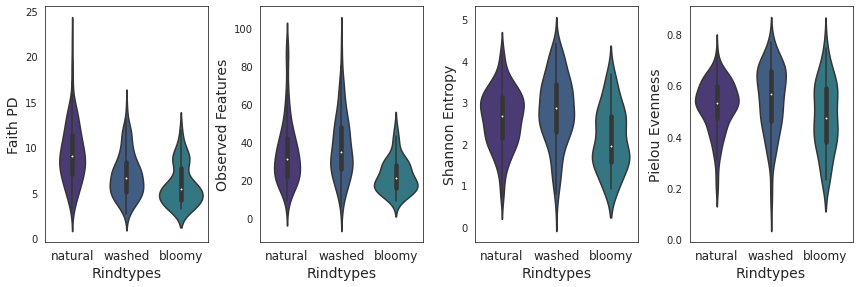

In [195]:
# violin plots for rindtype
with sns.axes_style("white"):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
    #fig.subplots_adjust(top=0.8)
    
    # just like above but the "axes" array is now two-dimensional
    ax1 = sns.violinplot(data=subset1, x='rindtype', y='faith_pd', ax=axes[0])
    ax2 = sns.violinplot(data=subset1, x='rindtype', y='observed_features', ax=axes[1])
    ax3 = sns.violinplot(data=subset1, x='rindtype', y='shannon_entropy', ax=axes[2])
    ax4 = sns.violinplot(data=subset1, x='rindtype', y='pielou_evenness', ax=axes[3])

fig.tight_layout()
    
sns.set_palette("tab10")

# set title and labels for individual plots
#ax1.set_title('Faith PD', fontsize=12)
ax1.set_ylabel('Faith PD', fontsize=14)
ax1.set_xlabel('Rindtypes', fontsize=14)
ax1.tick_params(axis='x', labelsize=12)
ax2.set_ylabel('Observed Features', fontsize=14)
ax2.set_xlabel('Rindtypes', fontsize=14)
ax2.tick_params(axis='x', labelsize=12)
# ax2.yaxis.set_label_position("right")
# better left with more space in between:
#fig.tight_layout(h_pad=3)

ax3.set_ylabel('Shannon Entropy', fontsize=14)
ax3.set_xlabel('Rindtypes', fontsize=14)
ax3.tick_params(axis='x', labelsize=12)
ax4.set_ylabel('Pielou Evenness', fontsize=14)
ax4.set_xlabel('Rindtypes', fontsize=14)
ax4.tick_params(axis='x', labelsize=12)

# title for the figure removed, as it's for the report
# fig.suptitle('alpha diversity metrics of different rindtypes', fontsize=16, y= 1.02);

#and finaly let's save the figure :D
#fig.savefig("rindtypes_metrics_violinplot_14.png", dpi = 400)

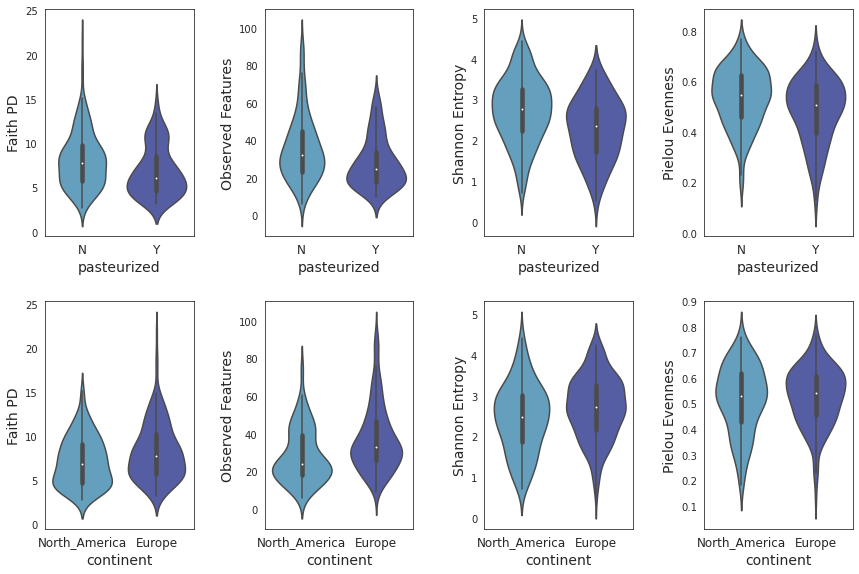

In [183]:
#pasteurization and continents

with sns.axes_style("white"):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))
    #fig.subplots_adjust(top=0.8)
    

    
    # just like above but the "axes" array is now two-dimensional
    ax1 = sns.violinplot(data=subset2, x='pasteurized', y='faith_pd', ax=axes[0,0])
    ax2 = sns.violinplot(data=subset2, x='pasteurized', y='observed_features', ax=axes[0,1])
    ax3 = sns.violinplot(data=subset2, x='pasteurized', y='shannon_entropy', ax=axes[0,2])
    ax4 = sns.violinplot(data=subset2, x='pasteurized', y='pielou_evenness', ax=axes[0,3])
    ax5 = sns.violinplot(data=subset2, x='continent', y='faith_pd', ax=axes[1,0])
    ax6 = sns.violinplot(data=subset2, x='continent', y='observed_features', ax=axes[1,1])
    ax7 = sns.violinplot(data=subset2, x='continent', y='shannon_entropy', ax=axes[1,2])
    ax8 = sns.violinplot(data=subset2, x='continent', y='pielou_evenness', ax=axes[1,3])

    fig.tight_layout(w_pad=3, h_pad=3)

# set title and labels for individual plots

ax1.set_ylabel('Faith PD', fontsize=14)
ax1.set_xlabel('pasteurized', fontsize=14)
ax1.tick_params(axis='x', labelsize=12)

ax2.set_ylabel('Observed Features', fontsize=14)
ax2.set_xlabel('pasteurized', fontsize=14)
ax2.tick_params(axis='x', labelsize=12)

ax3.set_ylabel('Shannon Entropy', fontsize=14)
ax3.set_xlabel('pasteurized', fontsize=14)
ax3.tick_params(axis='x', labelsize=12)

ax4.set_ylabel('Pielou Evenness', fontsize=14)
ax4.set_xlabel('pasteurized', fontsize=14)
ax4.tick_params(axis='x', labelsize=12)

ax5.set_ylabel('Faith PD', fontsize=14)
ax5.set_xlabel('continent', fontsize=14)
ax5.tick_params(axis='x', labelsize=12)

ax6.set_ylabel('Observed Features', fontsize=14)
ax6.set_xlabel('continent', fontsize=14)
ax6.tick_params(axis='x', labelsize=12)

ax7.set_ylabel('Shannon Entropy', fontsize=14)
ax7.set_xlabel('continent', fontsize=14)
ax7.tick_params(axis='x', labelsize=12)

ax8.set_ylabel('Pielou Evenness', fontsize=14)
ax8.set_xlabel('continent', fontsize=14)
ax8.tick_params(axis='x', labelsize=12)

# title for the figure removed, as it's for the report
# fig.suptitle('alpha diversity metrics of different rindtypes', fontsize=16, y= 1.02);

#and finaly let's save the figure :D
#fig.savefig("rindtypes_metrics_violinplot_14.png", dpi = 400)

In [ ]:
# violin plots for rindtype
with sns.axes_style("white"):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
    #fig.subplots_adjust(top=0.8)
    
    # just like above but the "axes" array is now two-dimensional
    ax1 = sns.violinplot(data=subset1, x='rindtype', y='faith_pd', ax=axes[0])
    ax2 = sns.violinplot(data=subset1, x='rindtype', y='observed_features', ax=axes[1])
    ax3 = sns.violinplot(data=subset1, x='rindtype', y='shannon_entropy', ax=axes[2])
    ax4 = sns.violinplot(data=subset1, x='rindtype', y='pielou_evenness', ax=axes[3])

fig.tight_layout()

# set title and labels for individual plots
#ax1.set_title('Faith PD', fontsize=12)
ax1.set_ylabel('Faith PD', fontsize=14)
ax1.set_xlabel('Rindtypes', fontsize=14)
ax1.tick_params(axis='x', labelsize=12)
ax2.set_ylabel('Observed Features', fontsize=14)
ax2.set_xlabel('Rindtypes', fontsize=14)
ax2.tick_params(axis='x', labelsize=12)
# ax2.yaxis.set_label_position("right")
# better left with more space in between:
#fig.tight_layout(h_pad=3)

ax3.set_ylabel('Shannon Entropy', fontsize=14)
ax3.set_xlabel('Rindtypes', fontsize=14)
ax3.tick_params(axis='x', labelsize=12)
ax4.set_ylabel('Pielou Evenness', fontsize=14)
ax4.set_xlabel('Rindtypes', fontsize=14)
ax4.tick_params(axis='x', labelsize=12)

# title for the figure removed, as it's for the report
# fig.suptitle('alpha diversity metrics of different rindtypes', fontsize=16, y= 1.02);

#and finaly let's save the figure :D
#fig.savefig("rindtypes_metrics_violinplot_14.png", dpi = 400)

In [ ]:
# violin plots for animal source
with sns.axes_style("white"):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
    #fig.subplots_adjust(top=0.8)
    
    # just like above but the "axes" array is now two-dimensional
    ax1 = sns.violinplot(data=subset1, x='rindtype', y='faith_pd', ax=axes[0])
    ax2 = sns.violinplot(data=subset1, x='rindtype', y='observed_features', ax=axes[1])
    ax3 = sns.violinplot(data=subset1, x='rindtype', y='shannon_entropy', ax=axes[2])
    ax4 = sns.violinplot(data=subset1, x='rindtype', y='pielou_evenness', ax=axes[3])

fig.tight_layout()

# set title and labels for individual plots
#ax1.set_title('Faith PD', fontsize=12)
ax1.set_ylabel('Faith PD', fontsize=14)
ax1.set_xlabel('Rindtypes', fontsize=14)
ax1.tick_params(axis='x', labelsize=12)
ax2.set_ylabel('Observed Features', fontsize=14)
ax2.set_xlabel('Rindtypes', fontsize=14)
ax2.tick_params(axis='x', labelsize=12)
# ax2.yaxis.set_label_position("right")
# better left with more space in between:
#fig.tight_layout(h_pad=3)

ax3.set_ylabel('Shannon Entropy', fontsize=14)
ax3.set_xlabel('Rindtypes', fontsize=14)
ax3.tick_params(axis='x', labelsize=12)
ax4.set_ylabel('Pielou Evenness', fontsize=14)
ax4.set_xlabel('Rindtypes', fontsize=14)
ax4.tick_params(axis='x', labelsize=12)

# title for the figure removed, as it's for the report
# fig.suptitle('alpha diversity metrics of different rindtypes', fontsize=16, y= 1.02);

#and finaly let's save the figure :D
#fig.savefig("rindtypes_metrics_violinplot_14.png", dpi = 400)

In [ ]:
# violin plots for countries
with sns.axes_style("white"):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
    #fig.subplots_adjust(top=0.8)
    
    # just like above but the "axes" array is now two-dimensional
    ax1 = sns.violinplot(data=subset1, x='rindtype', y='faith_pd', ax=axes[0])
    ax2 = sns.violinplot(data=subset1, x='rindtype', y='observed_features', ax=axes[1])
    ax3 = sns.violinplot(data=subset1, x='rindtype', y='shannon_entropy', ax=axes[2])
    ax4 = sns.violinplot(data=subset1, x='rindtype', y='pielou_evenness', ax=axes[3])

fig.tight_layout()

# set title and labels for individual plots
#ax1.set_title('Faith PD', fontsize=12)
ax1.set_ylabel('Faith PD', fontsize=14)
ax1.set_xlabel('Rindtypes', fontsize=14)
ax1.tick_params(axis='x', labelsize=12)
ax2.set_ylabel('Observed Features', fontsize=14)
ax2.set_xlabel('Rindtypes', fontsize=14)
ax2.tick_params(axis='x', labelsize=12)
# ax2.yaxis.set_label_position("right")
# better left with more space in between:
#fig.tight_layout(h_pad=3)

ax3.set_ylabel('Shannon Entropy', fontsize=14)
ax3.set_xlabel('Rindtypes', fontsize=14)
ax3.tick_params(axis='x', labelsize=12)
ax4.set_ylabel('Pielou Evenness', fontsize=14)
ax4.set_xlabel('Rindtypes', fontsize=14)
ax4.tick_params(axis='x', labelsize=12)

# title for the figure removed, as it's for the report
# fig.suptitle('alpha diversity metrics of different rindtypes', fontsize=16, y= 1.02);

#and finaly let's save the figure :D
#fig.savefig("rindtypes_metrics_violinplot_14.png", dpi = 400)

---

In [6]:
faith = q2.Artifact.load(os.path.join(data_dir, 'core-metrics-results_insertion_12000/faith_pd_vector.qza')).view(pd.Series)
obs_feat = q2.Artifact.load(os.path.join(data_dir, 'core-metrics-results_insertion_12000/observed_features_vector.qza')).view(pd.Series)
shannon = q2.Artifact.load(os.path.join(data_dir, 'core-metrics-results_insertion_12000/shannon_vector.qza')).view(pd.Series)
evenness = q2.Artifact.load(os.path.join(data_dir, 'core-metrics-results_insertion_12000/evenness_vector.qza')).view(pd.Series)
salt = pd.read_csv(os.path.join(data_dir, 'food-metadata.tsv'), sep='\t', index_col=0)['salt']
moisture = pd.read_csv(os.path.join(data_dir, 'food-metadata.tsv'), sep='\t', index_col=0)['moisture']

In [52]:
salt_sorted = salt.sort_values(ascending = False)
salt_sorted
moist_sorted = moisture.sort_values(ascending = False)
moist_sorted

sample-id
#q2:types       categorical
11488.CSB389    9.302325581
11488.CSB354    9.090909091
11488.CSB357    8.045977011
11488.CSB653    75.42297418
                   ...     
11488.CSB545            NaN
11488.CSB556            NaN
11488.CSB683            NaN
11488.CSB907            NaN
11488.CSB908            NaN
Name: moisture, Length: 355, dtype: object

In [7]:
faith_salt_moist = pd.concat([faith, salt, moisture], join = 'inner', axis = 1)
faith_salt_moist['salt'] = pd.to_numeric(faith_salt_moist['salt'], errors ='coerce')
faith_salt_moist['moisture'] = pd.to_numeric(faith_salt_moist['moisture'], errors ='coerce')
faith_salt_moist['faith_pd'] = pd.to_numeric(faith_salt_moist['faith_pd'], errors ='coerce')

In [8]:
metrics_salt_moist = pd.concat([faith, obs_feat, shannon, evenness, salt, moisture], join = 'inner', axis = 1)
metrics_salt_moist

,faith_pd,observed_features,shannon_entropy,pielou_evenness,salt,moisture
11488.CSB280,9.111393,25,1.641100,0.353392,0.045997737,34.80519481
11488.CSB281,10.492586,24,2.611748,0.569633,0.068926154,31.33333333
11488.CSB282,9.983138,23,2.348323,0.519131,0.030862483,34.90566038
11488.CSB290,4.539658,15,2.502991,0.640661,0.220927133,18.88111888
11488.CSB292,3.130709,12,2.353644,0.656532,0.0850591,22.89156627
...,...,...,...,...,...,...
11488.CSB980,8.061571,24,1.923263,0.419472,0.134996023,28.20512821
11488.CSB981,6.614198,20,1.473463,0.340927,0.102762839,25.76153177
11488.CSB984,10.555242,20,2.549971,0.590008,0.285081837,28.84012539
11488.CSB985,11.277596,56,2.460126,0.423623,0.109716632,24.9661705


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


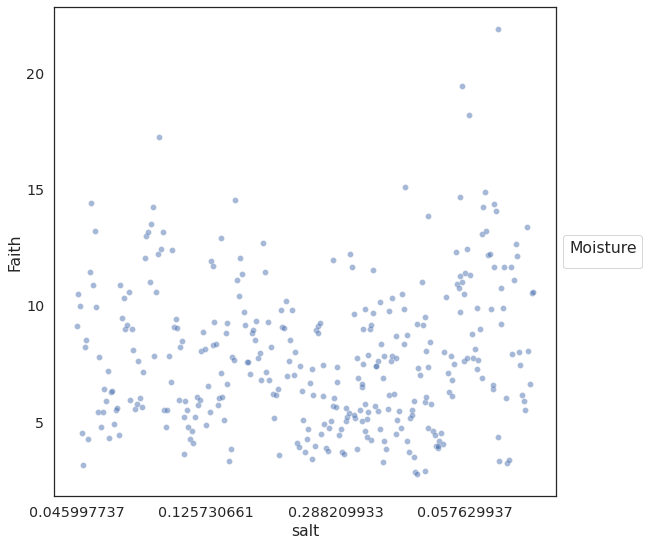

In [9]:
sns.set(rc={'figure.figsize':(9, 9), 'font.family': ['DejaVu Sans']}, style='white')
with sns.plotting_context("notebook", font_scale=1.3):
    # seaborn's scatter plot
    ax = sns.scatterplot(
        x=metrics_salt_moist['salt'], 
        y=metrics_salt_moist['faith_pd'],
        alpha=0.5,
    )


    # matplotlib's customization
    ax.set_xlabel('salt')
    ax.set_ylabel('Faith')
        

    ax.tick_params(axis='x', which='minor', bottom=True)
    ax.tick_params(axis='y', which='minor', left=True)
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    legend = ax.get_legend()
    legend.set_title('Moisture')

    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))

In [ ]:
    xticks = np.arange(5, 71, 10)
    ax.set_xticks(xticks)
    yticks = np.arange(0, 25, 0.2)
    ax.set_yticks(yticks)

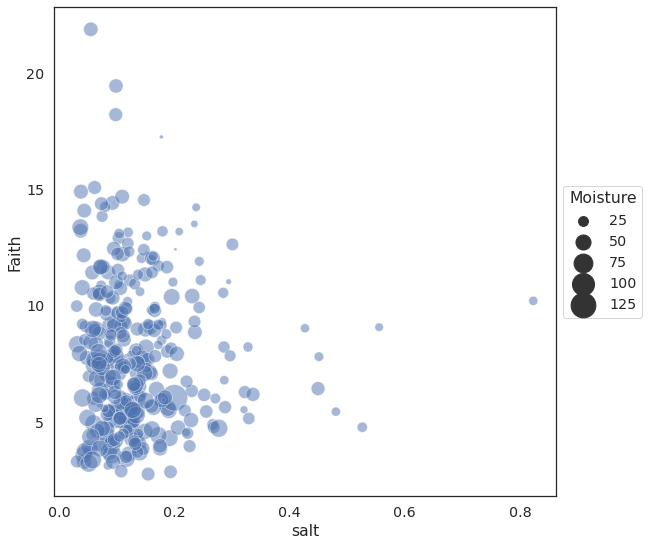

In [83]:
sns.set(rc={'figure.figsize':(9, 9), 'font.family': ['DejaVu Sans']}, style='white')
with sns.plotting_context("notebook", font_scale=1.3):
    # seaborn's scatter plot
    ax = sns.scatterplot(
        x=faith_salt_moist['salt'], 
        y=faith_salt_moist['faith_pd'], 
        size=faith_salt_moist['moisture'],
        sizes=(10, 700),
        alpha=0.5,
    )


    # matplotlib's customization
    ax.set_xlabel('salt')
    ax.set_ylabel('Faith')
        

    ax.tick_params(axis='x', which='minor', bottom=True)
    ax.tick_params(axis='y', which='minor', left=True)
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    legend = ax.get_legend()
    legend.set_title('Moisture')

    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    

---

## Beta diversity

Beta diversity measures the similarity between samples or groups of samples.

### 9) Analysis of core metrics qzv files
Analyse beta diversity from core-metrics-phylogenetic action. Unweigthed as well as weighted UniFrac, Jaccard and Bray-Curtis was visualized and inspected using the qzv files created under 5). 

Some clustering according to rindtype. But no clear clustering.

#### Unweighted UniFrac

In [2]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/unweighted_unifrac_emperor.qzv')

<visualization: Visualization uuid: a2b6d310-3dc4-4b74-b5e1-5dca1757868a>

#### Jaccard

In [3]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/jaccard_emperor.qzv')

<visualization: Visualization uuid: 029aa592-6da7-47a0-b555-69b4699a25a6>

#### Weighted UniFrac

In [4]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/weighted_unifrac_emperor.qzv')

<visualization: Visualization uuid: 0ac6d0cf-9c35-4e0c-94df-13ea3cf90a8c>

#### Bray-Curtis

In [5]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/bray_curtis_emperor.qzv')

<visualization: Visualization uuid: c6fb4009-624b-4ed3-8d6a-00233543c1e4>

### PERMANOVA test
Statistical testing of associations between beta diversity and categorical variables.
We perform a PERMANOVA test checking whether the observed categories are significantly grouped in QIIME 2 with the qiime diversity beta-group-significance method.

Inspect the beta diversity metrics of rindtype groupings:

Result: Distances between samples in groups are significantly different from the distance between samples from the other groups as the p-values are all 0.001.

In [19]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $data_dir/core-metrics-results_insertion_12000/unweighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/food-metadata.tsv \
    --m-metadata-column rindtype \
    --p-pairwise \
    --o-visualization $data_dir/core-metrics-results_insertion_12000/uw_unifrac-rindtype-significance.qzv

Saved Visualization to: CE/core-metrics-results_insertion_12000/uw_unifrac-rindtype-significance.qzv


In [20]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/uw_unifrac-rindtype-significance.qzv')

<visualization: Visualization uuid: 5dd44b9b-0dc0-4f31-8502-6f40fbdf7432>

Inspect the beta diversity metrics of continent groupings:

Result: 

In [21]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $data_dir/core-metrics-results_insertion_12000/unweighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/food-metadata.tsv \
    --m-metadata-column continent \
    --p-pairwise \
    --o-visualization $data_dir/core-metrics-results_insertion_12000/uw_unifrac-continent-significance.qzv

Saved Visualization to: CE/core-metrics-results_insertion_12000/uw_unifrac-continent-significance.qzv


In [22]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/uw_unifrac-continent-significance.qzv')

<visualization: Visualization uuid: 45cb541f-6e82-478a-80ac-d9fdd1398355>

Inspect the beta diversity metrics of animal source groupings:

In [23]:
! qiime diversity beta-group-significance \
    --i-distance-matrix $data_dir/core-metrics-results_insertion_12000/unweighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/food-metadata.tsv \
    --m-metadata-column animal_source \
    --p-pairwise \
    --o-visualization $data_dir/core-metrics-results_insertion_12000/uw_unifrac-animal-significance.qzv

Saved Visualization to: CE/core-metrics-results_insertion_12000/uw_unifrac-animal-significance.qzv


In [24]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/uw_unifrac-animal-significance.qzv')

<visualization: Visualization uuid: 4e0b7922-abef-46c0-a0d1-2e4660041a6b>

#### ADONIS

PERMANOVA test can also be performed with the adonis implementation. --> to explain which covariates explain the most variation in our dataset.

Order in formula can make a difference in the outcomes. --> try different orders

In [26]:
! qiime diversity adonis \
    --i-distance-matrix $data_dir/core-metrics-results_insertion_12000/unweighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/food-metadata.tsv \
    --p-formula "rindtype+continent+country+region+animal_source+pasteurized" \
    --o-visualization $data_dir/core-metrics-results_insertion_12000/adonis.qzv

Saved Visualization to: CE/core-metrics-results_insertion_12000/adonis.qzv


In [6]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/adonis.qzv')

<visualization: Visualization uuid: 86634dd3-26e3-4461-9178-3c1a29f9e932>

Order the columns for --p-formula by their R2 from the adonis thest performed before. The highest R2 comes first. This is important as order plays a role in adonis tests.

Result: The region explains the most variation in our dataset (highest R2 value). --> But where is "continent"? :(

In [30]:
! qiime diversity adonis \
    --i-distance-matrix $data_dir/core-metrics-results_insertion_12000/unweighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/food-metadata.tsv \
    --p-formula "region+rindtype+country+animal_source+continent+pasteurized" \
    --o-visualization $data_dir/core-metrics-results_insertion_12000/adonis_2.qzv

Saved Visualization to: CE/core-metrics-results_insertion_12000/adonis_2.qzv


In [7]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/adonis_2.qzv')

<visualization: Visualization uuid: e32a5aa8-78de-4b35-b8a8-b3cf756ccf3d>

In [34]:
! qiime diversity adonis \
    --i-distance-matrix $data_dir/core-metrics-results_insertion_12000/unweighted_unifrac_distance_matrix.qza \
    --m-metadata-file $data_dir/food-metadata.tsv \
    --p-formula "region+rindtype+animal_source+pasteurized+country" \
    --o-visualization $data_dir/core-metrics-results_insertion_12000/adonis_3.qzv

Saved Visualization to: CE/core-metrics-results_insertion_12000/adonis_3.qzv


In [8]:
Visualization.load(f'{data_dir}/core-metrics-results_insertion_12000/adonis_3.qzv')

<visualization: Visualization uuid: 28d476db-653d-4869-8000-4d6c084888da>

#### PANDAS fun
creating 2 D plots for our report, having fun with different colours and metrics :)

In [5]:
unw_UF_pcoa_res_12000 = q2.Artifact.load(os.path.join(data_dir, 'core-metrics-results_insertion_12000/unweighted_unifrac_pcoa_results.qza'))
unw_UF_pcoa_res_12000 = unw_UF_pcoa_res_12000.view(OrdinationResults)
# let's just take the first 3 columns (i.e., first 3 PCoA axes)
unw_UF_pcoa_res_data_12000 = unw_UF_pcoa_res_12000.samples.iloc[:,:3]
# rename the columns for clarity
unw_UF_pcoa_res_data_12000.columns = ['Axis 1', 'Axis 2', 'Axis 3']

In [6]:
unw_UF_pcoa_res_data_12000.head(3)

,Axis 1,Axis 2,Axis 3
11488.CSB280,0.049976,0.008295,-0.268998
11488.CSB281,0.196987,0.149224,-0.089773
11488.CSB282,0.082988,0.043284,-0.248198


In [7]:
df_meta = pd.read_csv(f'{data_dir}/food-metadata.tsv', sep='\t', index_col=0)

Join this dataframe with metadata column:

In [8]:
unw_UF_pcoa_res_data_with_rindtype_12000 = unw_UF_pcoa_res_data_12000.join(df_meta['rindtype'])
unw_UF_pcoa_res_data_with_rindtype_12000.head()

,Axis 1,Axis 2,Axis 3,rindtype
11488.CSB280,0.049976,0.008295,-0.268998,natural
11488.CSB281,0.196987,0.149224,-0.089773,natural
11488.CSB282,0.082988,0.043284,-0.248198,natural
11488.CSB290,-0.175483,0.165197,-0.013238,washed
11488.CSB292,-0.299215,0.131027,0.022871,washed


Visualize data using Python visualization library seaborn:

<AxesSubplot:xlabel='Axis 1', ylabel='Axis 2'>

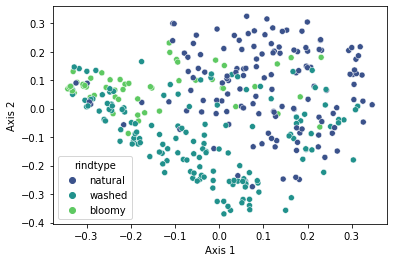

In [9]:
scatterplot(data=unw_UF_pcoa_res_data_with_rindtype_12000,
            x='Axis 1',
            y='Axis 2',
            hue='rindtype',
            palette='viridis')

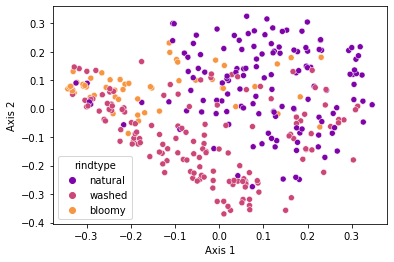

In [20]:
scatterplot(data=unw_UF_pcoa_res_data_with_rindtype_12000,
            x='Axis 1',
            y='Axis 2',
            hue='rindtype',
            palette='plasma')
plt.savefig("rindtype_plasma.png", dpi = 400)

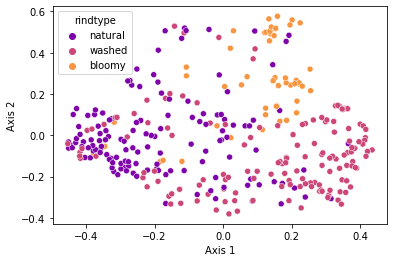

In [31]:
#style weighted unifrac
bray_curtis_pcoa_res_12000 = q2.Artifact.load(os.path.join(data_dir, 'core-metrics-results_insertion_12000/bray_curtis_pcoa_results.qza'))
bray_curtis_pcoa_res_12000 = bray_curtis_pcoa_res_12000.view(OrdinationResults)
# let's just take the first 3 columns (i.e., first 3 PCoA axes)
bray_curtis_pcoa_res_data_12000 = bray_curtis_pcoa_res_12000.samples.iloc[:,:3]
# rename the columns for clarity
bray_curtis_pcoa_res_data_12000.columns = ['Axis 1', 'Axis 2', 'Axis 3']

bray_curtis_pcoa_res_data_with_rindtype_12000 = bray_curtis_pcoa_res_data_12000.join(df_meta['rindtype'])
bray_curtis_pcoa_res_data_with_rindtype_12000.head()
scatterplot(data=bray_curtis_pcoa_res_data_with_rindtype_12000,
            x='Axis 1',
            y='Axis 2',
            hue='rindtype',
            palette='plasma')
plt.savefig("rindtype_bray_curtis_plasma.png", dpi = 400)

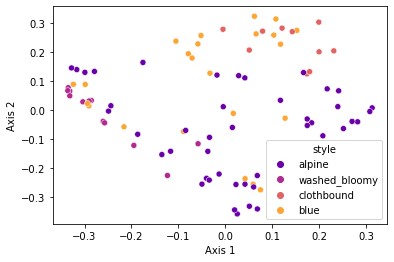

In [19]:
#style unweighted unifrac
unw_UF_pcoa_res_data_with_style_12000 = unw_UF_pcoa_res_data_12000.join(df_meta['style'])
unw_UF_pcoa_res_data_with_style_12000.head()
scatterplot(data=unw_UF_pcoa_res_data_with_style_12000,
            x='Axis 1',
            y='Axis 2',
            hue='style',
            palette='plasma')
plt.savefig("style_plasma.png", dpi = 400)

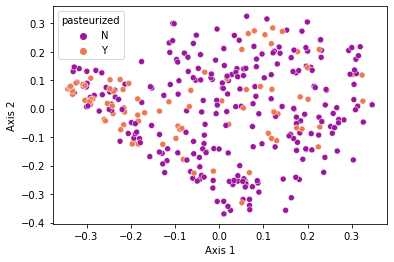

In [21]:
#pasteurized unweighted unifrac
unw_UF_pcoa_res_data_with_pasteurized_12000 = unw_UF_pcoa_res_data_12000.join(df_meta['pasteurized'])
unw_UF_pcoa_res_data_with_pasteurized_12000.head()
scatterplot(data=unw_UF_pcoa_res_data_with_pasteurized_12000,
            x='Axis 1',
            y='Axis 2',
            hue='pasteurized',
            palette='plasma')
plt.savefig("pasteurized_plasma.png", dpi = 400)

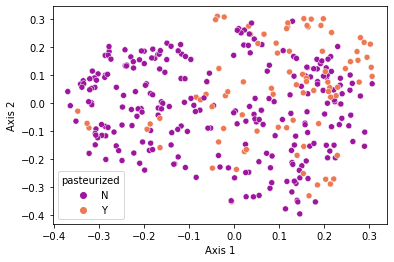

In [30]:
#style weighted unifrac
jaccard_pcoa_res_12000 = q2.Artifact.load(os.path.join(data_dir, 'core-metrics-results_insertion_12000/jaccard_pcoa_results.qza'))
jaccard_pcoa_res_12000 = jaccard_pcoa_res_12000.view(OrdinationResults)
# let's just take the first 3 columns (i.e., first 3 PCoA axes)
jaccard_pcoa_res_data_12000 = jaccard_pcoa_res_12000.samples.iloc[:,:3]
# rename the columns for clarity
jaccard_pcoa_res_data_12000.columns = ['Axis 1', 'Axis 2', 'Axis 3']

jaccard_pcoa_res_data_with_pasteurized_12000 = jaccard_pcoa_res_data_12000.join(df_meta['pasteurized'])
jaccard_pcoa_res_data_with_pasteurized_12000.head()
scatterplot(data=jaccard_pcoa_res_data_with_pasteurized_12000,
            x='Axis 1',
            y='Axis 2',
            hue='pasteurized',
            palette='plasma')
plt.savefig("pasteurized_jaccard_plasma.png", dpi = 400)

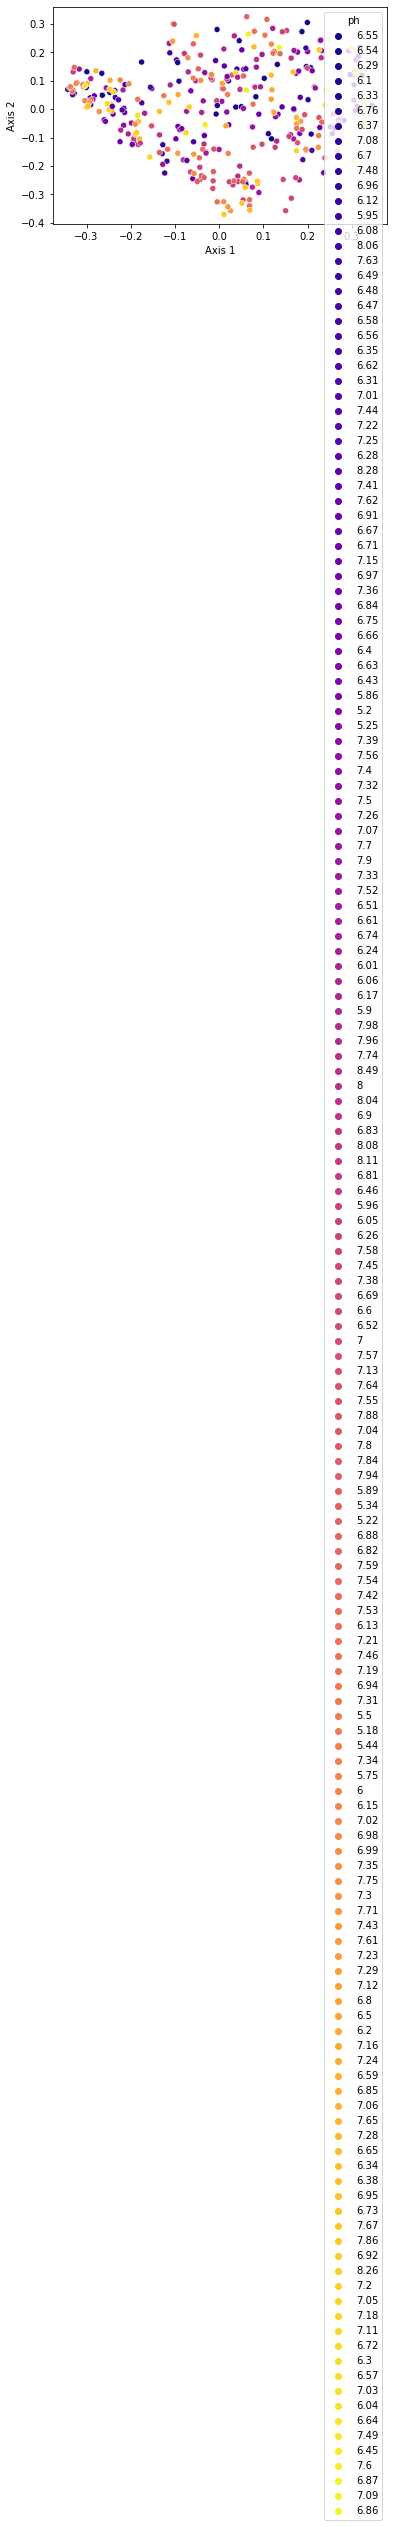

In [23]:
#pH
unw_UF_pcoa_res_data_with_ph_12000 = unw_UF_pcoa_res_data_12000.join(df_meta['ph'])
unw_UF_pcoa_res_data_with_ph_12000.head()
scatterplot(data=unw_UF_pcoa_res_data_with_ph_12000,
            x='Axis 1',
            y='Axis 2',
            hue='ph',
            palette='plasma')
plt.savefig("ph_plasma.png", dpi = 400)
#visible, that there is no gradient

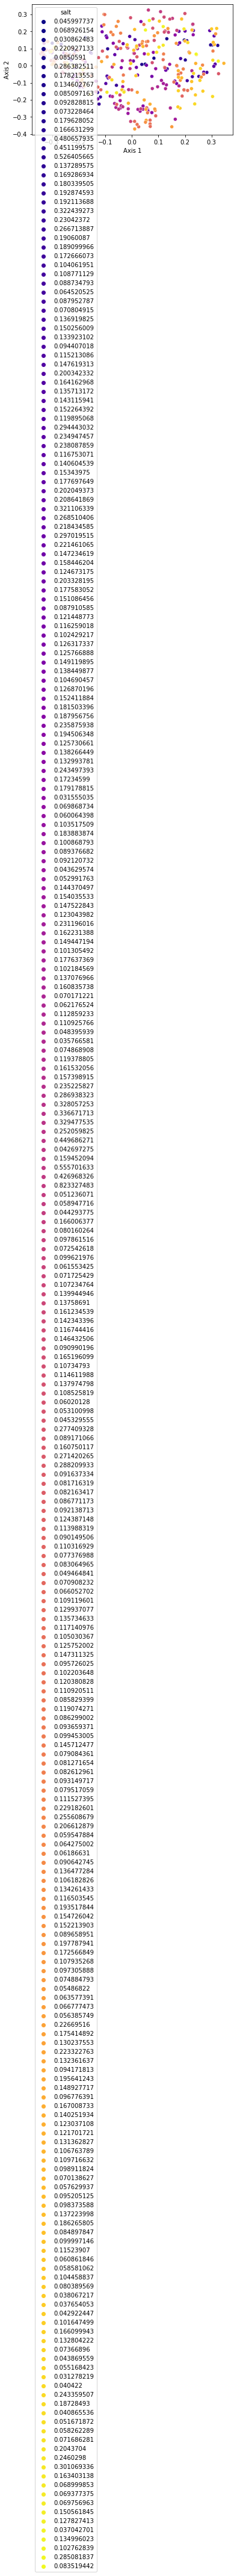

In [24]:
#salt
unw_UF_pcoa_res_data_with_salt_12000 = unw_UF_pcoa_res_data_12000.join(df_meta['salt'])
unw_UF_pcoa_res_data_with_salt_12000.head()
scatterplot(data=unw_UF_pcoa_res_data_with_salt_12000,
            x='Axis 1',
            y='Axis 2',
            hue='salt',
            palette='plasma')
plt.savefig("salt_plasma.png", dpi = 400)
#visible, that there is no gradient